In [1]:
from pathlib import Path
import os
os.chdir('/Users/stepankadocnikov/Documents/GitHub/woe-transformer')
print(os.getcwd())

/Users/stepankadocnikov/Documents/GitHub/woe-transformer


In [7]:
import json
import warnings
import math
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from woeTransformer_class import WoeTransformer, WoeTransformerRegularized

from collections import defaultdict
from tqdm.notebook import tqdm
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification

from utils import *

%load_ext autoreload
%aimport utils
%aimport woeTransformer_class
%autoreload 1

In [8]:
train_data = generate_train_data()
test_data = generate_test_data()


In [9]:
X, y = make_classification(5000, 20, 5, 0, weights=(0.95, 0.05), shift=5, scale=2)
X = pd.DataFrame(X)
for i, f in enumerate(X.columns):
    if i <= 9:
        X[f] = X[f].astype(int)
    if i & 2 == 0:
        ind = np.random.choice(range(len(X)), 500, replace=False)
        X.loc[ind, f] = np.nan
    X[f] = X[f].astype(str)
y = pd.Series(y, name='target')
X[0].name

0

In [10]:
n_seeds = 1
alphas = [0, 0.0001, 0.001, 0.01, 0.02, .03]

In [33]:
vanilla = WoeTransformer()
vanilla.fit(X.iloc[:,:5], y, opt_alpha_values={0:0, 1:.1})


WoeTransformer(min_sample_rate=0.05, min_count=3, n_fitted_predictors=5)

In [43]:
regul = WoeTransformerRegularized(alphas_list=alphas, n_seeds=n_seeds)
regul.fit(train_data.drop('target',axis=1), train_data['target'])
regul.opt_alpha_values

{'integers_w_letters': 0.03,
 'integers_w_letters_obj': 0.03,
 'letters': 0.001,
 'letters_uneq_freq': 0,
 'letters_w_na': 0,
 'single_letter': 0}

In [45]:
vanilla = WoeTransformer()
vanilla.fit(train_data.drop('target',axis=1), train_data['target'], opt_alpha_values=regul.opt_alpha_values)

WoeTransformer(min_sample_rate=0.05, min_count=3, n_fitted_predictors=15)

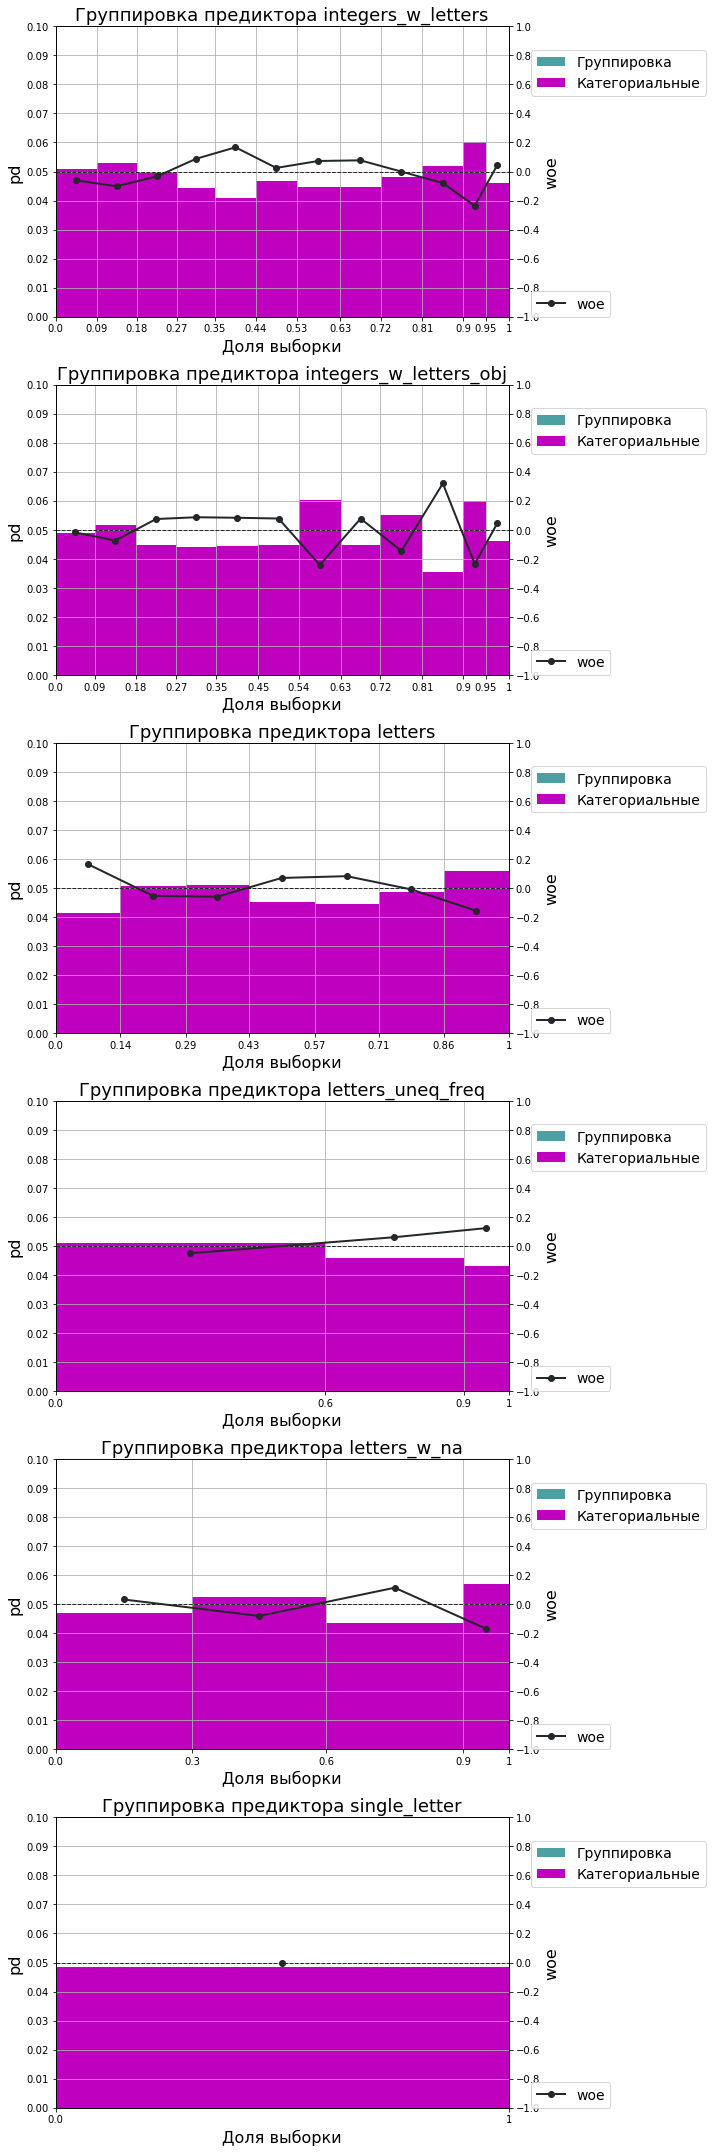

In [48]:
vanilla.plot_woe(list(regul.opt_alpha_values.keys()), show_unregul=False)


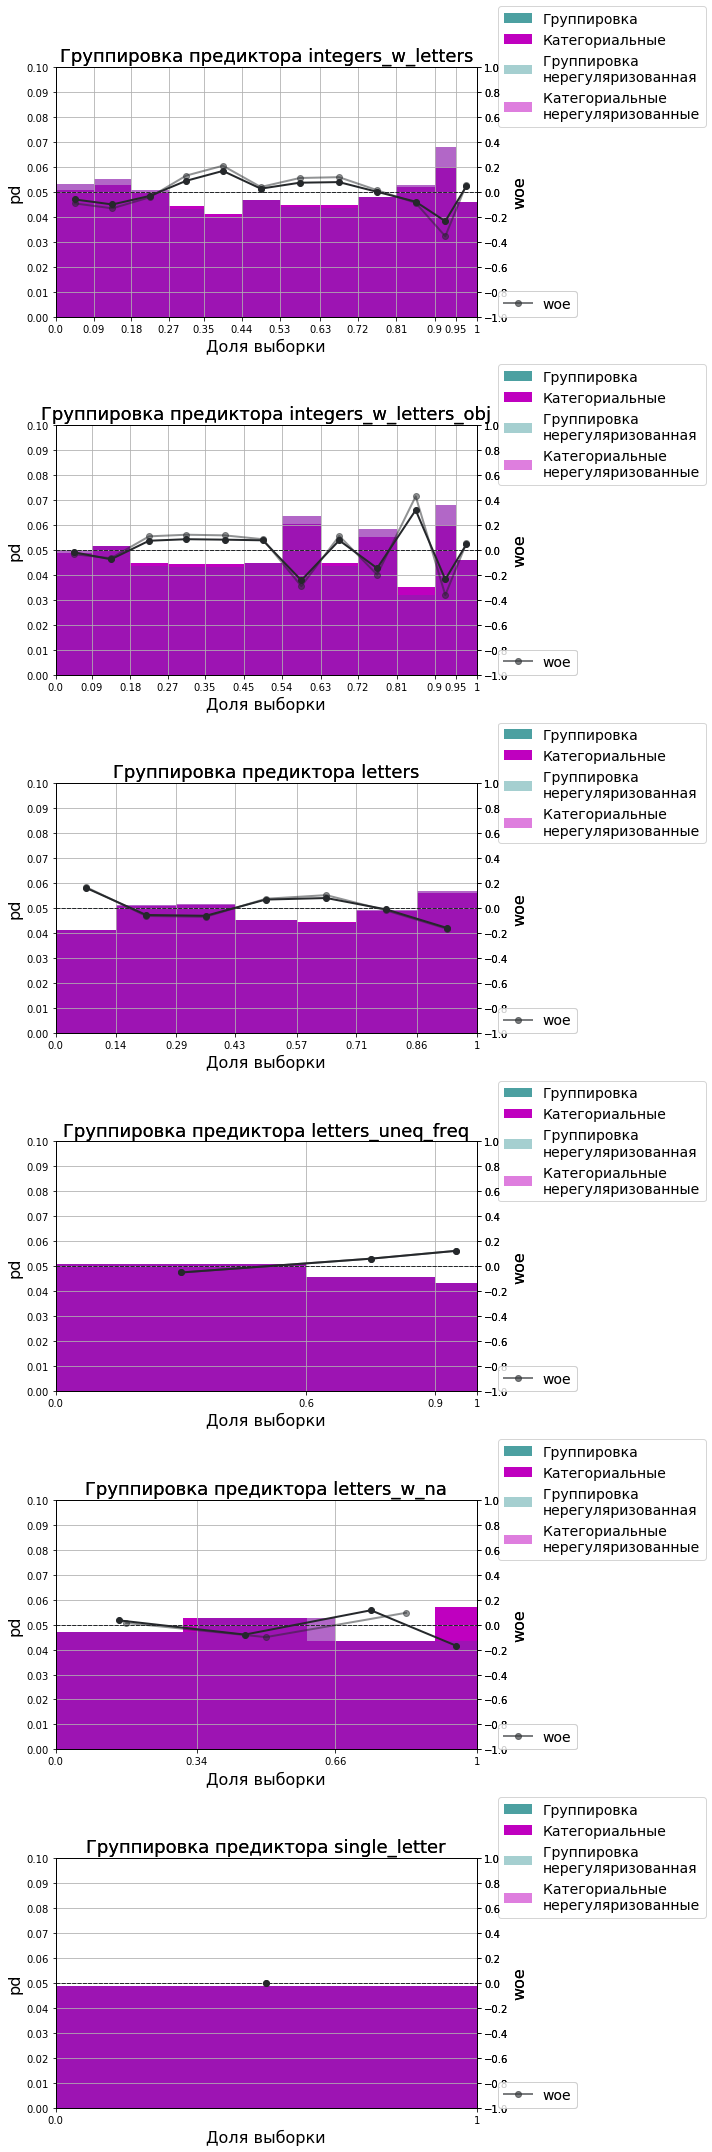

In [50]:
vanilla.plot_woe(list(regul.opt_alpha_values.keys()), show_unregul=True)

In [26]:
a = [[0, 0.203948491746367], 
     [0.0001, 0.20394840230562705], 
     [0.001, 0.2039206201054458], 
     [0.01, 0.2036637928958567], 
     [0.02, 0.20353968262545227], 
     [0.03, 0.20347955300751042]]
np.min(a, axis=0), np.argmin(a, 0), np.argmin(a, 0)[1], a[np.argmin(a, 0)[1]][0]

(array([0.        , 0.20347955]), array([0, 5]), 5, 0.03)

In [32]:
# Проверка расчета статистик функцией и классом
# regul_stats = (regul.stats[test_stats.columns]
#               .sort_values(['predictor', 'groups'])
#               .reset_index(drop=True)
#               .replace({'nan':'NO_INFO'}))
data = pd.concat([X, y], axis=1)
data.columns = ['col_'+str(i) for i in data.columns[:-1]] + ['target']
test_stats = pd.DataFrame()
for col in data.columns[:5]:
    tmp = cat_features_alpha_logloss(data, col, 'target', alphas, n_seeds, plot_i=False)
    print(col, tmp)

col_0 0.03
col_1 0.03
col_2 0.001
col_3 0.02
col_4 0.03


In [30]:
# функция WOE преобразования и расчета IV для датафрейма с готовой группировкой
def IVWOE(DF_groups):
    """
    Функция WOE преобразования и расчета IV для датафрейма с готовой группировкой
    Расчет статистики по группам
    DF_groups[['sample_count', 'target_count', 'groups']] - таблица данных по группам
    """
    nothing = 10 ** -6 # для случаев когда нет целевых событий для значения переменной
    DF_statistic = DF_groups
    DF_statistic['sample_rate'] = DF_statistic['sample_count'] / DF_statistic['sample_count'].sum()
    DF_statistic['target_rate'] = DF_statistic['target_count'] / DF_statistic['sample_count']
    
    # Расчет WoE и IV
    samples_num = DF_statistic['sample_count'].sum()
    events = DF_statistic['target_count'].sum()
    non_events = samples_num - events
    
    DF_statistic['non_events_i'] = DF_statistic['sample_count'] - DF_statistic['target_count']
    DF_statistic['event_rate_i'] = DF_statistic['target_count'] / events
    DF_statistic['non_event_rate_i'] = DF_statistic['non_events_i'] / non_events
    
    DF_statistic['WOE'] = [math.log(DF_statistic['non_event_rate_i'][i] / (DF_statistic['event_rate_i'][i] + nothing) + nothing) for i in DF_statistic.index]
    DF_statistic['IV'] = DF_statistic['WOE'] * (DF_statistic['non_event_rate_i'] - DF_statistic['event_rate_i'])
   
    return DF_statistic

In [31]:
# функция расчета IV, GINI и logloss для категориальных переменных с корректировкой целевой по alpha
from sklearn.metrics import log_loss


def cat_features_alpha_logloss(df, predictor, target, alpha, seed = 100, plot_i = False):
    """
    функция расчета IV, GINI и logloss для категориальных переменных с корректировкой целевой по alpha
    
    """

    L_logloss_mean = []
    GINI_IV_mean = []
    for alpha_i in alpha:
        logloss_i = []
        GINI_i = []
        IV_i = []
        for seed_i in range(seed):
            X_train, X_test, y_train, y_test = train_test_split(df[[predictor]], df[target], 
                                                    test_size=0.3, random_state=seed_i, stratify=df[target])
            X_train = X_train.fillna('NO_INFO').astype(str)
            X_test = X_test.fillna('NO_INFO').astype(str)
            X_train[target] = y_train
            X_test[target] = y_test
            X_test = X_test[[predictor, target]]
            X_test_WOE = pd.DataFrame()
            X_test_WOE['Target'] = X_test[target]
            
            tmp = pd.crosstab(X_train[predictor], X_train[target], normalize='index')
            tmp.rename(columns={0:'Non Target', 1:'Target'}, inplace=True)
            tmp_values = pd.DataFrame({predictor: X_train[predictor].value_counts().index,
                                       'Values' : X_train[predictor].value_counts().values})
            tmp = pd.merge(tmp, tmp_values, how='left', on=predictor)
            tmp['Target_cnt'] = [int(x) for x in (tmp['Target'] * tmp['Values'])]
            
            # расчет оптимальной целевой для группы, формула и детали в видео
            # https://www.youtube.com/watch?v=g335THJxkto&list=PLLIunAIxCvT8ZYpC6-X7H0QfAQO9H0f-8&index=12&t=0s
            # pd = (y_local * K + Y_global * alpha) / (K + alpha)
            Y_global = y_train.mean()
            tmp['Target_transformed'] = ((tmp['Target']) * (tmp['Values'] / X_train.shape[0]) + Y_global * alpha_i) / ((tmp['Values'] / X_train.shape[0]) + alpha_i)
            tmp['Target_cnt_transformed'] = [math.floor(x) for x in tmp['Values'] * tmp['Target_transformed']]
            
            # если пустых значений = 1 - необходимо добавить в таблицу это значение
            if 'NO_INFO' not in tmp[predictor].values:
                tmp = tmp.append({predictor : 'NO_INFO',
                                'Non Target' : df[(df[predictor] == 'NO_INFO') & (df[target] == 0)].shape[0],
                                'Target' : df[(df[predictor] == 'NO_INFO') & (df[target] == 1)].shape[0],
                                'Values' : df[(df[predictor] == 'NO_INFO')].shape[0],
                                'Target_cnt' : df[(df[predictor] == 'NO_INFO') & (df[target] == 1)].shape[0],
                                'Target_transformed' : X_train[target].mean(),
                                'Target_cnt_transformed' : (df[(df[predictor] == 'NO_INFO')].shape[0]) * X_train[target].mean()
                               }, ignore_index=True)

            tmp.sort_values(by = 'Values', inplace=True, ascending=False)
            tmp = tmp.reset_index(drop=True)
            order = list(tmp[predictor])
            
            # расчет WOE и IV на Train
            df_i = tmp[['Values', 'Target_cnt_transformed', predictor]]
            df_i.rename(columns={'Values' : 'sample_count', 
                                 'Target_cnt_transformed' : 'target_count',
                                  predictor : 'groups'}, inplace=True)
            WOE_i = IVWOE(df_i)

            # задаем промежуточную функцию для WOE преобразования переменной из исходного датафрейма по рассчитанным WOE из IVWOE
            def calc_woe_i(row_value):
                if row_value not in WOE_i['groups']:
                    return 0
                else:
                    i = 0
                    while row_value not in WOE_i['groups'][i]: i += 1
                    return WOE_i['WOE'][i]

            X_test_WOE['WOE'] = X_test[predictor].apply(calc_woe_i)
            roc_auc_i = roc_auc_score(X_test_WOE['Target'], X_test_WOE['WOE'])
            
            
            X_test = pd.merge(X_test, tmp[[predictor, 'Target_transformed']], how='left', on=predictor)
            #print(X_test[X_test['Target_transformed'].isna()])
            
#             print(seed_i)
#             print(X_test['Target_transformed'].isnull().sum())
#             print(X_test['Target_transformed'].loc[X_test['Target_transformed'].isnull()])
#             print(np.isinf(X_test['Target_transformed']).sum())
            
#             logloss_i.append(log_loss(X_test[target], X_test['Target_transformed']))
            logloss_i.append(log_loss(X_test[target], X_test['Target_transformed'].fillna(0)))
            IV_i.append(WOE_i['IV'].sum())
            GINI_i.append(abs(2 * roc_auc_i - 1))
            
        L_logloss_mean.append([alpha_i, np.mean(logloss_i)])
        GINI_IV_mean.append([alpha_i, np.mean(GINI_i), np.mean(IV_i)])
        
    df_cat_features_alpha_GINI_IV = pd.DataFrame(GINI_IV_mean, columns=['alpha', 'GINI', 'IV'])
    
    df_cat_features_alpha_logloss = pd.DataFrame(L_logloss_mean, columns=['alpha', 'logloss'])
    logloss_min = df_cat_features_alpha_logloss['logloss'].min()
    alpha_opt = df_cat_features_alpha_logloss[df_cat_features_alpha_logloss['logloss'] == logloss_min]['alpha'].values[0]
    
#     print('feature =', predictor)
#     print('log loss min =', logloss_min)
#     print('alpha optimum =', alpha_opt)
    
    if plot_i:
        fig = plt.figure(figsize=(16, 8))
        ax = fig.add_subplot(111)
        ax.plot(df_cat_features_alpha_logloss['alpha'], df_cat_features_alpha_logloss['logloss'], label = 'logloss_test', marker='o', ms = 3, color = 'red')
        ax2 = ax.twinx()
        ax2.plot(df_cat_features_alpha_GINI_IV['alpha'], df_cat_features_alpha_GINI_IV['IV'], label = 'IV_train', marker='o', ms = 3, color = 'blue')
        ax2.plot(df_cat_features_alpha_GINI_IV['alpha'], df_cat_features_alpha_GINI_IV['GINI'], label = 'GINI_test', marker='o', ms = 3, color = 'green')
        
        ax_y_step = (max(df_cat_features_alpha_logloss['logloss']) - min(df_cat_features_alpha_logloss['logloss'])) * 0.1
        ax_y_min = min(df_cat_features_alpha_logloss['logloss']) - ax_y_step
        ax_y_max = max(df_cat_features_alpha_logloss['logloss']) + ax_y_step
        ax.set_ylim(ax_y_min, ax_y_max)
        
        ax2_y_step = (max(max(df_cat_features_alpha_GINI_IV['IV']), max(df_cat_features_alpha_GINI_IV['GINI'])) - min(min(df_cat_features_alpha_GINI_IV['IV']), min(df_cat_features_alpha_GINI_IV['GINI']))) * 0.1
        ax2_y_min = min(min(df_cat_features_alpha_GINI_IV['IV']), min(df_cat_features_alpha_GINI_IV['GINI'])) - ax2_y_step
        ax2_y_max = max(max(df_cat_features_alpha_GINI_IV['IV']), max(df_cat_features_alpha_GINI_IV['GINI'])) + ax2_y_step
        ax2.set_ylim(ax2_y_min, ax2_y_max)
        
        ax.tick_params(axis="x", labelsize=12)
        ax2.tick_params(axis="x", labelsize=12)
        ax.set_xlabel('alpha', fontsize=16)
        ax.set_ylabel('logloss', fontsize=16)
        ax2.set_ylabel('GINI and IV', fontsize=16)
        ax.legend(loc = "upper left")
        ax2.legend(loc = "upper right")
        plt.grid(True)
        plt.title('Распределение logloss, GINI и IV от значения alpha', fontsize=20)
        plt.show()
    
    return(alpha_opt)

## Тест на разнообразных данных

In [67]:
train_data

,digits,integers,floats,large_floats,integers_w_neg,integers_w_small_cat,floats_w_na,integers_w_letters,integers_w_letters_obj,letters,letters_uneq_freq,letters_w_na,single_integer,single_letter,single_nan,target
0,8,59,5.181818,137931.896552,32,8.0,2.0,5,2,d,b,c,1.0,x,NaN,0
1,5,39,4.454545,103449.172414,-37,3.0,8.0,9,9,e,a,b,1.0,x,NaN,0
2,6,73,4.454545,482759.137931,-19,8.0,8.0,1,5,g,a,a,1.0,x,NaN,0
3,4,39,2.181818,137931.896552,-15,2.0,3.0,9,6,a,a,b,1.0,x,NaN,0
4,5,58,8.363636,68966.448276,34,3.0,6.0,6,7,e,b,b,1.0,x,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,8,17,3.818182,482759.137931,-43,100.0,NaN,f,f,c,b,NaN,1.0,x,NaN,0
9996,7,55,4.181818,758620.931034,-5,100.0,NaN,d,d,d,c,NaN,1.0,x,NaN,0
9997,4,89,2.909091,34483.724138,9,100.0,NaN,f,f,f,a,NaN,1.0,x,NaN,0
9998,3,69,5.272727,241380.068966,-16,100.0,NaN,d,d,d,a,NaN,1.0,x,NaN,0


In [69]:
vanilla = WoeTransformer()
vanilla.fit(train_data.drop('target', axis=1), train_data['target'])


,predictor,groups,type,sample_count,target_count,min,max,sample_rate,target_rate,non_events_i,event_rate_i,non_event_rate_i,WOE,IV
0,digits,"(-inf, 6.0]",num,7031,366,0,6,0.7031,0.052055,6665,0.733467,0.701505,-4.455466e-02,1.424048e-03
1,digits,"(6.0, 8.0]",num,1999,90,7,8,0.1999,0.045023,1909,0.180361,0.200926,1.079743e-01,2.220545e-03
2,digits,"(8.0, inf]",num,970,43,9,9,0.0970,0.044330,927,0.086172,0.097569,1.241965e-01,1.415385e-03
0,integers,"(-inf, 8.0]",num,884,34,0,8,0.0884,0.038462,850,0.069530,0.089370,2.510204e-01,4.980383e-03
1,integers,"(8.0, 61.0]",num,5228,255,9,61,0.5228,0.048776,4973,0.521472,0.522868,2.672282e-03,3.730148e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,letters_w_na,c,cat,2954,159,c,c,0.2954,0.053825,2795,0.318637,0.294180,-7.986511e-02,1.953318e-03
3,letters_w_na,NaN,cat,1000,43,NaN,NaN,0.1000,0.043000,957,0.086172,0.100726,1.560463e-01,2.271081e-03
0,single_integer,"(-inf, inf]",num,10000,499,1,1,1.0000,0.049900,9501,1.000000,1.000000,1.899752e-09,3.607165e-18
0,single_letter,x,cat,10000,499,x,x,1.0000,0.049900,9501,1.000000,1.000000,1.899752e-09,3.607165e-18


In [85]:
with pd.option_context('min_rows', 100, 'max_rows', 100):
    display(vanilla.stats)
    display(vanilla.transform(train_data))
    display(vanilla.transform(test_data))
    
# vanilla.borders

,predictor,groups,type,sample_count,target_count,min,max,sample_rate,target_rate,non_events_i,event_rate_i,non_event_rate_i,WOE,IV
0,digits,"(-inf, 6.0]",num,7031,366,0,6,0.7031,0.052055,6665,0.733467,0.701505,-4.455466e-02,1.424048e-03
1,digits,"(6.0, 8.0]",num,1999,90,7,8,0.1999,0.045023,1909,0.180361,0.200926,1.079743e-01,2.220545e-03
2,digits,"(8.0, inf]",num,970,43,9,9,0.0970,0.044330,927,0.086172,0.097569,1.241965e-01,1.415385e-03
0,integers,"(-inf, 8.0]",num,884,34,0,8,0.0884,0.038462,850,0.069530,0.089370,2.510204e-01,4.980383e-03
1,integers,"(8.0, 61.0]",num,5228,255,9,61,0.5228,0.048776,4973,0.521472,0.522868,2.672282e-03,3.730148e-06
2,integers,"(61.0, inf]",num,3888,200,62,99,0.3888,0.051440,3688,0.408998,0.387762,-5.332098e-02,1.132347e-03
0,floats,"(-inf, 2.909]",num,2211,101,1,2.90909,0.2211,0.045681,2110,0.207392,0.221802,6.716838e-02,9.678661e-04
1,floats,"(2.909, 3.455]",num,591,27,3,3.45455,0.0591,0.045685,564,0.055441,0.059287,6.704985e-02,2.578612e-04
2,floats,"(3.455, 5.455]",num,2199,107,3.54545,5.45455,0.2199,0.048658,2092,0.219713,0.219910,8.930003e-04,1.759855e-07
3,floats,"(5.455, 9.545]",num,4486,221,5.54545,9.54545,0.4486,0.049264,4265,0.453799,0.448334,-1.211687e-02,6.621759e-05


Column is not in fitted predictors list: target


,digits,integers,floats,large_floats,integers_w_neg,integers_w_small_cat,floats_w_na,integers_w_letters,integers_w_letters_obj,letters,letters_uneq_freq,letters_w_na,single_integer,single_letter,single_nan
0,0.107974,0.002672,0.000893,0.115828,-0.155209,-0.008968,-0.015073,0.164439,0.057474,-0.107473,0.019755,-0.079865,0,0,0
1,-0.044555,0.002672,0.000893,0.115828,0.216694,0.023329,-0.023820,-0.010833,0.239347,0.030626,0.019996,0.014825,0,0,0
2,-0.044555,-0.053321,0.000893,0.045256,-0.006643,-0.008968,-0.023820,-0.320981,-0.093139,0.091647,0.019996,0.018230,0,0,0
3,-0.044555,0.002672,0.067168,0.115828,-0.006643,0.023329,-0.015073,-0.010833,-0.057367,-0.098928,0.019996,0.014825,0,0,0
4,-0.044555,0.002672,-0.012117,0.115828,-0.155209,0.023329,-0.023820,0.165067,-0.089616,0.030626,0.019755,0.014825,0,0,0
5,-0.044555,-0.053321,0.067168,-0.131139,0.216694,-0.140601,-0.023820,0.069641,-0.171469,0.101626,0.019996,-0.079865,0,0,0
6,-0.044555,-0.053321,0.067050,0.045256,0.097341,0.023329,-0.023820,0.069641,-0.089616,0.101626,0.019996,0.018230,0,0,0
7,-0.044555,-0.053321,-0.012117,0.045256,-0.155209,-0.140601,-0.015073,0.011439,0.239347,-0.098928,0.019996,-0.079865,0,0,0
8,-0.044555,0.002672,-0.012117,0.045256,-0.006643,0.023329,-0.023820,-0.199245,-0.093139,-0.083209,0.019996,0.014825,0,0,0
9,-0.044555,0.002672,0.000893,0.045256,0.432595,-0.140601,-0.023820,-0.061545,0.239347,0.084166,0.019996,0.014825,0,0,0


Column is not in fitted predictors list: letters_crazy
Column is not in fitted predictors list: target


,digits,integers,floats,large_floats,integers_w_neg,integers_w_small_cat,floats_w_na,integers_w_letters,integers_w_letters_obj,letters,letters_uneq_freq,letters_w_na,single_integer,single_letter,single_nan
0,0.107974,-0.053321,-0.228208,0.045256,-0.022713,0.023329,-0.023820,0.164439,0.239347,0.084166,0.019755,0.014825,0,0,0
1,-0.044555,0.002672,0.067168,0.115828,-0.022713,-0.008968,-0.023820,-0.010833,-0.057367,-0.098928,0.019755,-0.079865,0,0,0
2,-0.044555,0.002672,0.000893,0.045256,-0.155209,0.023329,-0.023820,-0.010833,0.132761,0.030626,0.019996,0.018230,0,0,0
3,0.107974,0.002672,-0.228208,0.045256,-0.003586,0.023329,-0.023820,0.094899,0.239347,-0.083209,0.019755,0.014825,0,0,0
4,-0.044555,-0.053321,-0.012117,-0.131139,-0.003586,0.023329,-0.015073,0.011439,0.239347,0.101626,0.019996,0.014825,0,0,0
5,-0.044555,0.002672,0.000893,0.045256,0.432595,-0.008968,-0.023820,0.164439,0.132761,0.030626,0.019755,0.014825,0,0,0
6,-0.044555,-0.053321,-0.228208,0.045256,0.432595,-0.008968,-0.023820,0.069641,-0.230055,0.084166,0.019755,0.000000,0,0,0
7,0.124196,0.002672,-0.228208,0.045256,-0.102846,0.023329,-0.023820,-0.199245,-0.230055,0.101626,0.019755,-0.079865,0,0,0
8,-0.044555,0.251020,-0.228208,-0.131139,-0.155209,0.023329,-0.023820,0.011439,0.239347,-0.083209,0.019996,-0.079865,0,0,0
9,-0.044555,-0.053321,-0.228208,0.045256,-0.006643,0.023329,-0.015073,-0.010833,-0.084914,-0.083209,0.019755,-0.079865,0,0,0


In [81]:
regul = WoeTransformerRegularized(alphas=[0, 0.1, 0.5], n_seeds=5)
regul.fit(train_data.drop('target', axis=1), train_data['target'], )


WoeTransformer(min_sample_rate=0.05, min_count=3, n_fitted_predictors=15)